In [ ]:
# Data Preprocess & Setup
import torch
import pandas as pd
import numpy as np

# Model
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import DataLoader
from torch import optim,nn
import torch.nn.functional as F

# Timer
import time

# Evaluation
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics
import seaborn as sns
from sklearn.metrics import classification_report

# installed
from torchvision import models,transforms

## Setup
### Data Preprocessing 

In [ ]:
# Device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
# Read data
df = pd.read_csv('sign_data/sign_mnist_train/sign_mnist_train.csv')

In [ ]:
df['label'].value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [ ]:
# classes
classes = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 
         6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 
         13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
         19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y' }

### Splitting Data


In [ ]:
# Training and Testing dataset
train = pd.read_csv('sign_data/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('sign_data/sign_mnist_test/sign_mnist_test.csv')

In [ ]:
# Replace lables to actual alphabets

train = train.replace({'label': classes})
test = test.replace({'label': classes})

### Transforming

In [ ]:
# Transforming

mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Transformation of train images

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

# Transformation of test images

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

### Data Loader

#### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
class sign_dataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
        self.image_info = self.df.iloc[:, 1:].values
        self.label_info = self.df.iloc[:, 0].values
        size = self.image_info.shape[0]
        
        self.image_info = np.reshape(self.image_info, 
                                     (size, 1, 28, 28)) / 255
        self.label_info = np.array(self.label_info)

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, index):

        image = self.image_info[index, :, :]
        
        label = self.label_info[index]
        
        result = {'image': image, 'label': label}
        
        return result

### Loading Data

In [ ]:
# Training Set
training_set = sign_dataset(train, transform=train_transform)
train_loader = DataLoader(dataset = dataset_train, batch_size = 4, shuffle=True)

# Testing Set
testing_set = sign_dataset(test, transform=test_transform)
test_loader = DataLoader(dataset = dataset_test, batch_size = 4, shuffle=False)

## Building models
### Preprocessing for models
#### https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        kernel_size_1 = (5,5)
        pool_size_1 = (2,2)
        
        self.conv_1 = nn.Conv2d(1, 16, kernel_size_1)
        self.maxpool1 = nn.MaxPool2d(pool_size_1, stride = 2, padding = 0)
        self.batch1 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(512, 250)
        
        self.conv_2 = nn.Conv2d(16, 32, kernel_size_1)
        self.maxpool2 = nn.MaxPool2d(pool_size_1, stride = 2, padding = 0)
        self.batch2 = nn.BatchNorm2d(32)
        self.fc2 = nn.Linear(250, 25)

    def forward(self, x):
        scores = None

        batch_1 = self.batch1(self.conv_1(x))
        relu_1 = F.relu(batch_1)
        pool_1 = self.maxpool1(relu_1)

        batch_2 = self.batch2(self.conv_2(pool_1))
        relu_2 = F.relu(batch_2)
        pool_2 = self.maxpool2(relu_2)
        
        view = pool_2.view(pool_2.size(0), -1)
        
        relu_3 = F.relu(self.fc1(view))
        fc = self.fc2(relu_3)
        
        scores = F.log_softmax(fc, dim=1)
        
        return scores


In [ ]:
def train(model, optimizer, epoch, device, train_loader, log_interval):
    model.train()
    for idx, data in enumerate(train_loader):
        
        x = data['image']
        x = x.type(torch.FloatTensor).to(device)
        
        y = data['label']
        y = y.type(torch.LongTensor).to(device)
        

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        optimizer.zero_grad()
         
        loss.backward()
        optimizer.step()
        
        if idx % log_interval == 0:
          e = epoch
          print('Epoch %d, Process %d, loss = %.4f' % (e, idx * len(x), loss.item()))

def check_accuracy(model, device, test_loader):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            
            x = data['image']
            x = x.type(torch.FloatTensor).to(device)
            y = data['label']
            y = y.type(torch.LongTensor).to(device)
            
            scores = model(x)
            _, pred = scores.max(1, keepdim=True)
            
            num_correct += pred.eq(y.view_as(pred)).sum()
            num_samples += pred.size(0)

    acc = num_correct / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100. * acc))
    return acc

In [ ]:
torch.manual_seed(777)

epochs = 20
learning_rate = 0.001

model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
accuracies = []
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, device, train_loader, 10000)
    accuracy = check_accuracy(model, device, test_loader)
    accuracies.append(accuracy)

end = time.time()
print(end - start)

Epoch 1, Process 0, loss = 3.1992
Got 5961 / 7172 correct (83.11%)
Epoch 2, Process 0, loss = 0.3767
Got 6392 / 7172 correct (89.12%)
Epoch 3, Process 0, loss = 0.1104
Got 6465 / 7172 correct (90.14%)
Epoch 4, Process 0, loss = 0.0126
Got 6621 / 7172 correct (92.32%)
Epoch 5, Process 0, loss = 0.0120
Got 6614 / 7172 correct (92.22%)
Epoch 6, Process 0, loss = 0.0166
Got 6655 / 7172 correct (92.79%)
Epoch 7, Process 0, loss = 0.0217
Got 6633 / 7172 correct (92.48%)
Epoch 8, Process 0, loss = 0.0098
Got 6651 / 7172 correct (92.74%)
Epoch 9, Process 0, loss = 0.0050
Got 6644 / 7172 correct (92.64%)
Epoch 10, Process 0, loss = 0.0006
Got 6668 / 7172 correct (92.97%)
Epoch 11, Process 0, loss = 0.0043
Got 6671 / 7172 correct (93.01%)
Epoch 12, Process 0, loss = 0.0042
Got 6675 / 7172 correct (93.07%)
Epoch 13, Process 0, loss = 0.0026
Got 6685 / 7172 correct (93.21%)
Epoch 14, Process 0, loss = 0.0019
Got 6667 / 7172 correct (92.96%)
Epoch 15, Process 0, loss = 0.0041
Got 6691 / 7172 correc

## Evaluation


In [ ]:
# Confusion Matrix
def confusion_matrix(model, testloader):
    model.eval()
    true = []
    pred = []
    with torch.no_grad():
        for index, data in enumerate(test_loader):
            
            x = data['image']
            x = x.type(torch.FloatTensor).to(device)
            y = data['label']
            y = y.type(torch.LongTensor).to(device)

            result = model(x)
            predicted = torch.argmax(result.data, 1)
            true.append(y.cpu().numpy())
            pred.append(predicted.cpu().numpy())

    true = np.hstack(true)
    pred = np.hstack(pred)

    return true, pred

Text(33.0, 0.5, 'True Label')

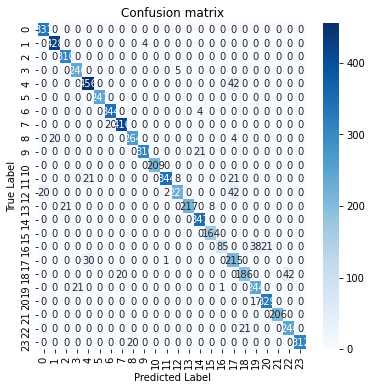

In [ ]:
true, pred = confusion_matrix(model, test_loader)

cf_matrix = skmetrics.confusion_matrix(true, pred)

plt.figure(figsize=(6, 6))

plt.title("Confusion matrix")
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Text(0.5, 0, 'epoch')

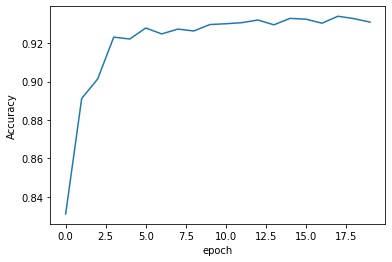

In [ ]:
# Accuracy
plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('epoch')

In [ ]:
true_1 = pd.DataFrame(true)
pred_1 = pd.DataFrame(pred)
true_1 = true_1.replace({0: classes})
pred_1 = pred_1.replace({0: classes})

report = classification_report(true_1, pred_1)
print(report)

              precision    recall  f1-score   support

           A       0.94      1.00      0.97       331
           B       0.96      0.99      0.97       432
           C       0.94      1.00      0.97       310
           D       0.92      0.98      0.95       245
           E       0.90      0.92      0.91       498
           F       1.00      1.00      1.00       247
           G       0.95      0.99      0.97       348
           H       0.95      0.95      0.95       436
           I       0.93      0.92      0.92       288
           K       0.99      0.94      0.96       331
           L       1.00      1.00      1.00       209
           M       0.99      0.87      0.93       394
           N       0.95      0.78      0.85       291
           O       1.00      0.88      0.94       246
           P       0.93      1.00      0.97       347
           Q       0.95      1.00      0.98       164
           R       0.99      0.59      0.74       144
           S       0.66    

### Reference:

#### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

#### https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py